# CNN Validation
Check the performance of the CNN on the validation set

- Compute the precision and recall curves
- find the threshold score that achieves 99% precision on the validation set
- check precision and recall for various thresholds (for testing robustness of temporal patterns to change of threshold)


This notebook is part of a series of notebooks and scripts in the [repository](https://github.com/kitzeslab/rana-sierrae-cnn):

- `01_explore_annotated_data.ipynb` Explore annotated dataset of Rana sierrae call types

- `02_prep_training_data.ipynb` Prepare annotated files for training a CNN machine learning model

- `03_train_cnn.ipynb` Train a CNN to recognize Rana sierrae vocaliztaions

- `04_cnn_prediction.ipynb` Use the cnn to detect Rana sierrae in audio recordings

- `05_cnn_validation.ipynb` Analyze the accuracy and performance of the CNN

- `06_aggregate_scores.py` Aggregate scores from CNN prediction across dates and times of day

- `07_explore_results.ipynb` Analyze temporal patterns of vocal activity using the CNN detections


### imports
import required packages

In [1]:
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for big visuals
%config InlineBackend.figure_format = 'retina'

### plotting settings

In [2]:
from matplotlib import pyplot as plt

# create style sheet?
# plt.style.use('./styles/sam.mplstyle')

small_txt = 7
med_txt = 8
big_txt = 8
# set text sizes
plt.rcParams['font.size'] = small_txt
plt.rcParams['axes.labelsize'] = med_txt
plt.rcParams['axes.titlesize'] = big_txt
plt.rcParams['xtick.labelsize'] = small_txt
plt.rcParams['ytick.labelsize'] = small_txt
plt.rcParams['legend.fontsize'] = med_txt
plt.rcParams['figure.titlesize'] = big_txt
# opaque legend (<1 is not fully opaque)
plt.rcParams["legend.framealpha"] = 1.0
# set figure size
plt.rcParams['figure.figsize']=[6,2.5]
plt.rcParams['figure.dpi'] = 300
# set default font
# plt.rcParams['font.sans-serif'] = "Gill Sans"
# plt.rcParams['font.family'] = "sans-serif"
# plt.rcParams['font.sans-serif'] = "gillsans"


# TIP use these 2 lines to list all available fonts:
# from matplotlib import font_manager
# font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# to add a font
# on linux, add .ttf font files to /usr/share/fonts/truetype/
# then follow these instructions https://scentellegher.github.io/visualization/2018/05/02/custom-fonts-matplotlib.html 

# tell matplotlib to create vector fonts 
# so you can edit them later! eg in Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# plt.rcParams['lines.markersize'] = 1


#color and line style cycles #
# TIP: use https://coolers.co to create nice color palettes
#or modify this one https://coolors.co/35aad8-f3b61f-ba3b54-45b69c-8a96d7
from cycler import cycler
default_cycler = (cycler(color=['#35aad8','#f3b61f','#8a96d7','#45b69c','#ba3b54']) 
                  # + cycler(linestyle=['-', '--', '-.', ':','-'])
                 )
plt.rc('lines', linewidth=0.5)
plt.rc('axes', prop_cycle=default_cycler)

#use appropriate resolution for retina screens
%config InlineBackend.figure_format='retina'

## Load the labels and CNN prediction scores for the validation set

In [3]:
val_df = pd.read_csv('./resources/validation_labels_and_scores.csv')
val_df.head(2)

,file,start_time,end_time,rana_sierrae,score
0,./rana_sierrae_2022/mp3/sine2022a_MSD-0558_202...,0.0,2.0,0,0.027761
1,./rana_sierrae_2022/mp3/sine2022a_MSD-0558_202...,0.5,2.5,0,0.023385


## Calculate metrics and visualize performance

In [4]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc

In [5]:
p,r,t = precision_recall_curve(val_df['rana_sierrae'],val_df['score'])
print(f"Average precision: {average_precision_score(val_df['rana_sierrae'],val_df['score'])}")
print(f"Area under ROC curve: {roc_auc_score(val_df['rana_sierrae'],val_df['score'])}")
print(f"Area under P-R curve: {auc(r,p)}")

Average precision: 0.9187549944446871
Area under ROC curve: 0.951881297624947
Area under P-R curve: 0.9186412082012038


### Plot precision and recall versus threshold

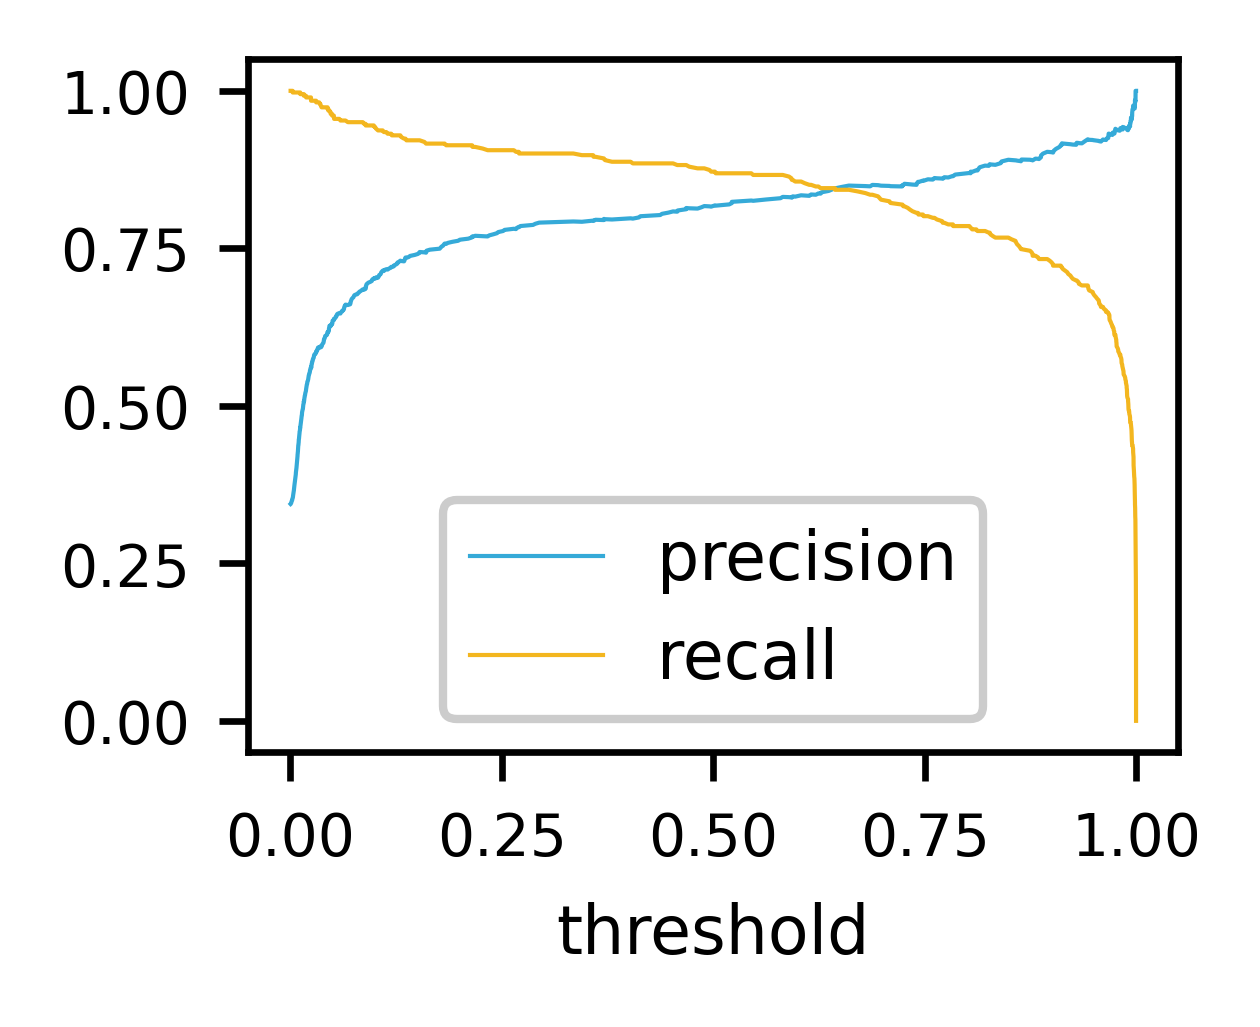

In [6]:
plt.figure(figsize=(2,1.5)) 
plt.plot(t,p[1:],label='precision')
plt.plot(t,r[1:],label='recall')
plt.xlabel('threshold')
plt.legend()
plt.savefig('./figures/precision_and_recall_vs_threshold.pdf')

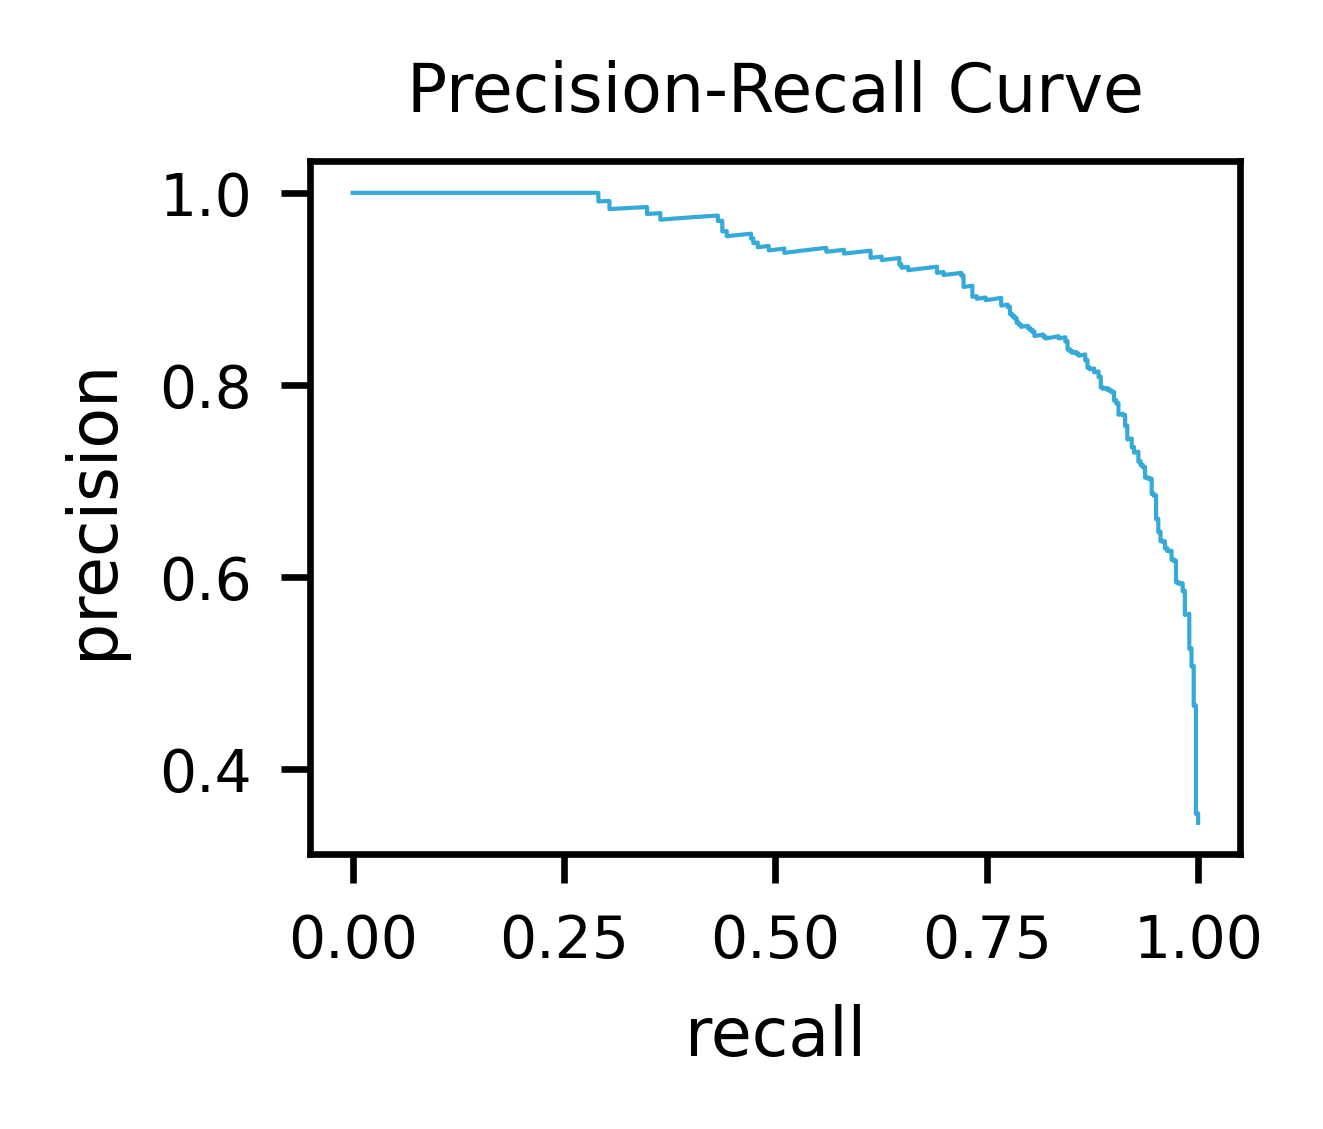

In [7]:
plt.figure(figsize=(2,1.5)) 
plt.plot(r,p)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall Curve')
plt.savefig('./figures/precision_recall_curve.pdf')

## Find the threshold that achieves 99% precision:

For >99% precision, we choose the threshold 0.99933 for the analyses shown in the manuscript,

In [8]:
first_threshold_w_prec099 = np.argmax((p>0.99)[1:]) + 1
print(f"threshold for 99% precision: {t[first_threshold_w_prec099]}")
print(f"precision: {p[first_threshold_w_prec099]}")
print(f"recall: {r[first_threshold_w_prec099]}")

threshold for 99% precision: 0.9993486
precision: 0.9914529914529915
recall: 0.3036649214659686


## precision and recall at thresholds shown in figures
We chose a range of thresholds to test the robustness of observed temporal patterns to threshold score (and therefore robustness to varying precision and recall). 

We chose thresholds for logit(score) in {0,2,4,6,8,10}

We also evaluate the threshold logit(0.9993342)=7.3139 which is the threshold used in the main body results of the manuscript for 99% precision

In [9]:
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score
from torch import tensor, sigmoid

In [10]:
thresholds = [0,2,4,6,7.3139,8,10]
for t in thresholds:
    th = float(sigmoid(tensor(t)))
    print(f"threshold: {t} precision: {precision_score(val_df['rana_sierrae'], (val_df.score>th)):0.2f} recall: {recall_score(val_df['rana_sierrae'], (val_df.score>th)):0.2f}")

threshold: 0 precision: 0.82 recall: 0.87
threshold: 2 precision: 0.89 recall: 0.74
threshold: 4 precision: 0.94 recall: 0.58
threshold: 6 precision: 0.97 recall: 0.40
threshold: 7.3139 precision: 0.98 recall: 0.30
threshold: 8 precision: 1.00 recall: 0.25
threshold: 10 precision: 1.00 recall: 0.12
